# Julia for Data Analysis

## Bogumił Kamiński

# Lecture 7. Handling time series data and missing values

## Getting data from the NBP Web API

### Standard process of parsing JSON response

In [1]:
using HTTP
using JSON3
query = "https://api.nbp.pl/api/exchangerates/rates/a/usd/2020-06-01/?format=json"

"https://api.nbp.pl/api/exchangerates/rates/a/usd/2020-06-01/?format=json"

In [2]:
response = HTTP.get(query)

HTTP.Messages.Response:
"""
HTTP/1.1 200 OK
Date: Thu, 10 Nov 2022 16:36:52 GMT
Cache-Control: no-cache
Pragma: no-cache
Content-Type: application/json; charset=utf-8
Expires: -1
ETag: "LtSHBbDU2y3KsMJ9eJZYpzdCA7SQZFfj5BzU1098bVg="
Vary: Accept-Encoding
Content-Encoding: gzip
Set-Cookie: ee3la5eizeiY4Eix=iePaevi0; path=/
Transfer-Encoding: chunked

{"table":"A","currency":"dolar amerykański","code":"USD","rates":[{"no":"105/A/NBP/2020","effectiveDate":"2020-06-01","mid":3.9680}]}"""

In [3]:
json = JSON3.read(response.body)

JSON3.Object{Vector{UInt8}, Vector{UInt64}} with 4 entries:
  :table    => "A"
  :currency => "dolar amerykański"
  :code     => "USD"
  :rates    => JSON3.Object[{…

In [4]:
response.body

134-element Vector{UInt8}:
 0x7b
 0x22
 0x74
 0x61
 0x62
 0x6c
 0x65
 0x22
 0x3a
 0x22
 0x41
 0x22
 0x2c
    ⋮
 0x64
 0x22
 0x3a
 0x33
 0x2e
 0x39
 0x36
 0x38
 0x30
 0x7d
 0x5d
 0x7d

In [5]:
String(response.body)

"{\"table\":\"A\",\"currency\":\"dolar amerykański\",\"code\":\"USD\",\"rates\":[{\"no\":\"105/A/NBP/2020\",\"effectiveDate\":\"2020-06-01\",\"mid\":3.9680}]}"

In [6]:
response.body

UInt8[]

In [7]:
json.table

"A"

In [8]:
json.currency

"dolar amerykański"

In [9]:
json.code

"USD"

In [10]:
json.rates

1-element JSON3.Array{JSON3.Object, Vector{UInt8}, SubArray{UInt64, 1, Vector{UInt64}, Tuple{UnitRange{Int64}}, true}}:
 {
              "no": "105/A/NBP/2020",
   "effectiveDate": "2020-06-01",
             "mid": 3.968
}

In [11]:
json.rates[1].mid

3.968

In [12]:
only(json.rates).mid

3.968

In [13]:
only([])

LoadError: ArgumentError: Collection is empty, must contain exactly 1 element

In [14]:
only([1,2])

LoadError: ArgumentError: Collection has multiple elements, must contain exactly 1 element

### Handling cases when NBP Web API query fails

In [15]:
query = "https://api.nbp.pl/api/exchangerates/rates/a/usd/2020-06-06/?format=json"

"https://api.nbp.pl/api/exchangerates/rates/a/usd/2020-06-06/?format=json"

In [16]:
response = HTTP.get(query)

LoadError: HTTP.Exceptions.StatusError(404, "GET", "/api/exchangerates/rates/a/usd/2020-06-06/?format=json", HTTP.Messages.Response:
"""
HTTP/1.1 404 Not Found
Date: Thu, 10 Nov 2022 16:36:58 GMT
Cache-Control: no-cache
Pragma: no-cache
Content-Length: 38
Content-Type: text/plain; charset=utf-8
Expires: -1

404 NotFound - Not Found - Brak danych""")

In [17]:
query = "https://api.nbp.pl/api/exchangerates/rates/a/usd/2020-06-01/?format=json"

"https://api.nbp.pl/api/exchangerates/rates/a/usd/2020-06-01/?format=json"

In [18]:
try
    response = HTTP.get(query)
    json = JSON3.read(response.body)
    only(json.rates).mid
catch e
    if e isa HTTP.ExceptionRequest.StatusError
        missing
    else
        rethrow(e)
    end
end

3.968

In [19]:
query = "https://api.nbp.pl/api/exchangerates/rates/a/usd/2020-06-06/?format=json"

"https://api.nbp.pl/api/exchangerates/rates/a/usd/2020-06-06/?format=json"

In [20]:
try
    response = HTTP.get(query)
    json = JSON3.read(response.body)
    only(json.rates).mid
catch e
    if e isa HTTP.ExceptionRequest.StatusError
        missing
    else
        rethrow(e)
    end
end

missing

## Missing data in Julia

In [21]:
ismissing(missing)

true

In [22]:
ismissing(1)

false

### Propagation of missing values

In [23]:
1 + missing

missing

In [24]:
sin(missing)

missing

In [25]:
1 == missing

missing

In [26]:
1 > missing

missing

In [27]:
1 < missing

missing

### Three-valued logic

In [28]:
if missing
    print("this is not printed")
end

LoadError: TypeError: non-boolean (Missing) used in boolean context

In [29]:
missing && true

LoadError: TypeError: non-boolean (Missing) used in boolean context

In [30]:
coalesce(missing, true)

true

In [31]:
coalesce(missing, false)

false

### Comparison guaranteeing Boolean result

In [32]:
isequal(1, missing)

false

In [33]:
isequal(missing, missing)

true

In [34]:
isless(1, missing)

true

In [35]:
isless(missing, missing)

false

In [36]:
isless(Inf, missing)

true

In [37]:
a = [1]

1-element Vector{Int64}:
 1

In [38]:
b = [1]

1-element Vector{Int64}:
 1

In [39]:
isequal(a, b)

true

In [40]:
a === b

false

### Replacing missing values in collections

In [41]:
x = [1, missing, 3, 4, missing]

5-element Vector{Union{Missing, Int64}}:
 1
  missing
 3
 4
  missing

In [42]:
coalesce.(x, 0)

5-element Vector{Int64}:
 1
 0
 3
 4
 0

### Skipping missing values

In [43]:
sum(x)

missing

In [44]:
y = skipmissing(x)

skipmissing(Union{Missing, Int64}[1, missing, 3, 4, missing])

In [45]:
sum(y)

8

In [46]:
sum(skipmissing(x))

8

### Enabling `missing` value propagation in functions

In [47]:
fun(x::Int, y::Int) = x + y

fun (generic function with 1 method)

In [48]:
fun(1, 2)

3

In [49]:
fun(1, missing)

LoadError: MethodError: no method matching fun(::Int64, ::Missing)
[0mClosest candidates are:
[0m  fun(::Int64, [91m::Int64[39m) at In[47]:1

In [50]:
using Missings
fun2 = passmissing(fun)

(::Missings.PassMissing{typeof(fun)}) (generic function with 2 methods)

In [51]:
fun2(1, 2)

3

In [52]:
fun2(1, missing)

missing

## Working with dates

In [53]:
using Dates
d = Date("2020-06-01")

2020-06-01

In [54]:
typeof(d)

Date

In [55]:
year(d)

2020

In [56]:
month(d)

6

In [57]:
day(d)

1

In [58]:
dayofweek(d)

1

In [59]:
dayname(d)

"Monday"

In [60]:
Date(2020, 6, 1)

2020-06-01

In [61]:
dates = Date.(2020, 6, 1:30)

30-element Vector{Date}:
 2020-06-01
 2020-06-02
 2020-06-03
 2020-06-04
 2020-06-05
 2020-06-06
 2020-06-07
 2020-06-08
 2020-06-09
 2020-06-10
 2020-06-11
 2020-06-12
 2020-06-13
 ⋮
 2020-06-19
 2020-06-20
 2020-06-21
 2020-06-22
 2020-06-23
 2020-06-24
 2020-06-25
 2020-06-26
 2020-06-27
 2020-06-28
 2020-06-29
 2020-06-30

In [62]:
Day(1)

1 day

In [63]:
d

2020-06-01

In [64]:
d + Day(1)

2020-06-02

In [65]:
Date(2020, 5, 20):Day(1):Date(2020, 7, 5)

Date("2020-05-20"):Day(1):Date("2020-07-05")

In [66]:
collect(Date(2020, 5, 20):Day(1):Date(2020, 7, 5))

47-element Vector{Date}:
 2020-05-20
 2020-05-21
 2020-05-22
 2020-05-23
 2020-05-24
 2020-05-25
 2020-05-26
 2020-05-27
 2020-05-28
 2020-05-29
 2020-05-30
 2020-05-31
 2020-06-01
 ⋮
 2020-06-24
 2020-06-25
 2020-06-26
 2020-06-27
 2020-06-28
 2020-06-29
 2020-06-30
 2020-07-01
 2020-07-02
 2020-07-03
 2020-07-04
 2020-07-05

You can learn more about the rules of date arithmetic in the
[Julia Manual](https://docs.julialang.org/en/v1/stdlib/Dates/#TimeType-Period-Arithmetic).

Julia also allows you to work with time and date-time objects.
The details, as usual, can be found in the [Julia Manual](https://docs.julialang.org/en/v1/stdlib/Dates/).

## Fetching data from NBP Web API for a range of dates

In [67]:
function get_rate(date::Date)
    query = "https://api.nbp.pl/api/exchangerates/rates/a/usd/$date/?format=json"
    try
        response = HTTP.get(query)
        json = JSON3.read(response.body)
        return only(json.rates).mid
    catch e
        if e isa HTTP.ExceptionRequest.StatusError
            return missing
        else
            rethrow(e)
        end
    end
end

get_rate (generic function with 1 method)

In [68]:
d

2020-06-01

In [69]:
"d = $d"

"d = 2020-06-01"

In [70]:
"https://api.nbp.pl/api/exchangerates/rates/a/usd/$(dates[1])/?format=json"

"https://api.nbp.pl/api/exchangerates/rates/a/usd/2020-06-01/?format=json"

In [71]:
"https://api.nbp.pl/api/exchangerates/rates/a/usd/$dates[1]/?format=json"

"https://api.nbp.pl/api/exchangerates/rates/a/usd/[Date(\"2020-06-01\"), Date(\"2020-06-02\"), Date(\"2020-06-03\"), Date(\"2020-06-04\"), Date(\"2020-06-05\"), Date(\"2020-06-06\"), Date(\"2020-06-07\"), Date(\"2020-06-08\"), Date(\"2020-06-09\"), Date(\"2020-06-10\"), Date(\"2020-06-11\"), D" ⋯ 124 bytes ⋯ "\"2020-06-18\"), Date(\"2020-06-19\"), Date(\"2020-06-20\"), Date(\"2020-06-21\"), Date(\"2020-06-22\"), Date(\"2020-06-23\"), Date(\"2020-06-24\"), Date(\"2020-06-25\"), Date(\"2020-06-26\"), Date(\"2020-06-27\"), Date(\"2020-06-28\"), Date(\"2020-06-29\"), Date(\"2020-06-30\")][1]/?format=json"

In [72]:
rates = get_rate.(dates)

30-element Vector{Union{Missing, Float64}}:
 3.968
 3.9303
 3.9121
 3.9573
 3.9217
  missing
  missing
 3.9197
 3.9453
 3.918
  missing
 3.9299
  missing
 ⋮
 3.9741
  missing
  missing
 3.9667
 3.9311
 3.9395
 3.9623
 3.9697
  missing
  missing
 3.9656
 3.9806

## Analyzing the data fetched from NBP Web API

In [73]:
using Statistics

In [74]:
mean(rates)

missing

In [75]:
std(rates)

missing

In [76]:
mean(skipmissing(rates))

3.9452904761904755

In [77]:
std(skipmissing(rates))

0.022438959529396577

In [78]:
using FreqTables
proptable(dayname.(dates), ismissing.(rates); margins=1)

7×2 Named Matrix{Float64}
Dim1 ╲ Dim2 │ false   true
────────────┼─────────────
Friday      │   1.0    0.0
Monday      │   1.0    0.0
Saturday    │   0.0    1.0
Sunday      │   0.0    1.0
Thursday    │  0.75   0.25
Tuesday     │   1.0    0.0
Wednesday   │   1.0    0.0

In [79]:
dayname.(dates) .== "Thursday" .&& ismissing.(rates)

30-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [80]:
dates[dayname.(dates) .== "Thursday" .&& ismissing.(rates)]

1-element Vector{Date}:
 2020-06-11

## Plotting data with missing values

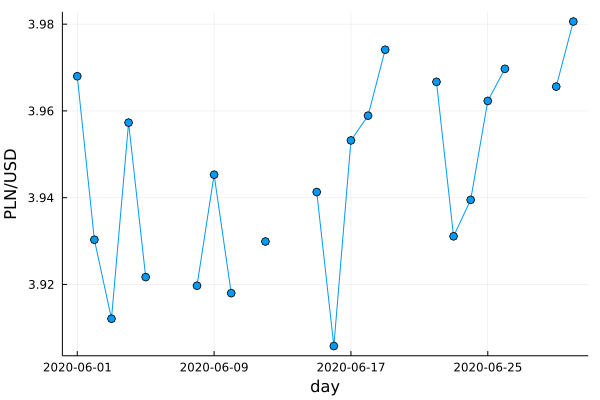

In [81]:
using Plots
plot(dates, rates;
xlabel="day", ylabel="PLN/USD", legend=false, marker=:o)

In [82]:
rates_ok = .!ismissing.(rates)

30-element BitVector:
 1
 1
 1
 1
 1
 0
 0
 1
 1
 1
 0
 1
 0
 ⋮
 1
 0
 0
 1
 1
 1
 1
 1
 0
 0
 1
 1

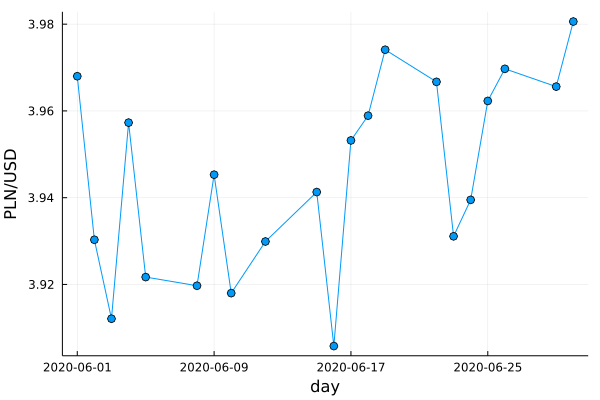

In [83]:
plot(dates[rates_ok], rates[rates_ok];
xlabel="day", ylabel="PLN/USD", legend=false, marker=:o)

In [84]:
using Impute
rates_filled = Impute.interp(rates)

30-element Vector{Union{Missing, Float64}}:
 3.968
 3.9303
 3.9121
 3.9573
 3.9217
 3.9210333333333334
 3.9203666666666668
 3.9197
 3.9453
 3.918
 3.92395
 3.9299
 3.9337
 ⋮
 3.9741
 3.971633333333333
 3.9691666666666663
 3.9667
 3.9311
 3.9395
 3.9623
 3.9697
 3.9683333333333333
 3.9669666666666665
 3.9656
 3.9806

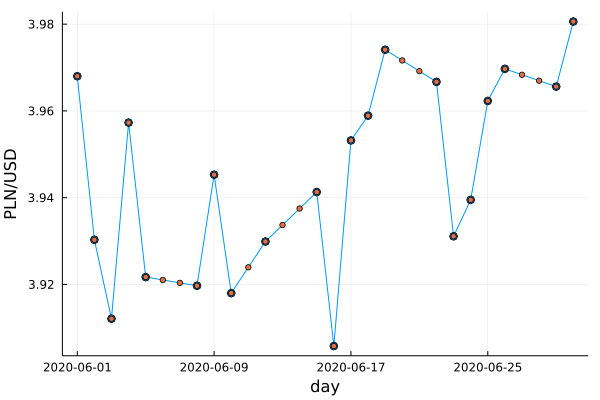

In [85]:
scatter!(dates, rates_filled, markersize=3)

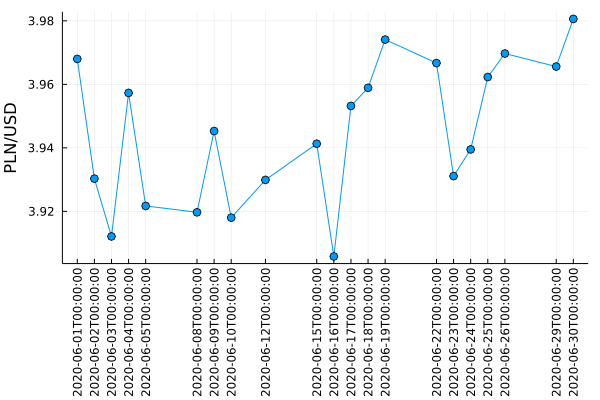

In [86]:
plot(dates[rates_ok], rates[rates_ok];
     xlabel="day", ylabel="PLN/USD", legend=false, marker=:o,
     xticks=dates[rates_ok], xrot=90, bottommargin=5Plots.mm)